In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
ozone = pd.read_csv('data/ozone.csv')
ozone.head()


,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
0,/2024,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
1,01/02/2024,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
2,/2024,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,January 04/2024,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,January 05/2024,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


In [74]:
ozone.isnull().sum()




Date                                       0
Source                                     0
Site ID                                    0
POC                                        0
Daily Max 8-hour Ozone Concentration    2738
Units                                      0
Daily AQI Value                         2738
Local Site Name                            0
Daily Obs Count                            0
Percent Complete                           0
Method Code                             6490
CBSA Code                               2408
CBSA Name                               2408
County FIPS Code                           0
County                                     0
Site Latitude                              0
Site Longitude                             0
dtype: int64

In [75]:
#Phase 1. Organizing the data
ozone_initial = ozone.shape[0]

      
#fixing column titles
ozone.columns = ozone.columns.str.replace(' ', '_').str.replace('-', '_').str.lower()
print(ozone.columns)

#dropna in concentration
ozone.dropna(subset=['daily_max_8_hour_ozone_concentration', 'daily_aqi_value'], inplace=True)
ozone_after_na_drop = ozone.shape[0]

print(f"DataFrame now has {ozone_after_na_drop} rows.")

#dropduplicates
ozone.drop_duplicates(inplace=True)
ozone_dropped_duplicates = ozone.shape[0]

#NA in method_code - replace with mode
mode_method = ozone['method_code'].mode()[0] 
ozone['method_code'].fillna(mode_method, inplace=True)



Index(['date', 'source', 'site_id', 'poc',
       'daily_max_8_hour_ozone_concentration', 'units', 'daily_aqi_value',
       'local_site_name', 'daily_obs_count', 'percent_complete', 'method_code',
       'cbsa_code', 'cbsa_name', 'county_fips_code', 'county', 'site_latitude',
       'site_longitude'],
      dtype='object')
DataFrame now has 49419 rows.


In [76]:
#converting "date" to datetime format

ozone['date'] = pd.to_datetime(ozone['date'], errors='coerce')
print(f"New 'date' dtype: {ozone['date'].dtype}")
parsed_date_nas = ozone['date'].isnull().sum()
if parsed_date_nas > 0:
    print(f"WARNING: {parsed_date_nas} 'date' values failed to parse and were converted to NaT.")

#Drop rows with NaT dates
    ozone_before_date_na_drop = ozone.shape[0]
    ozone.dropna(subset=['date'], inplace=True)
    ozone_after_date_na_drop = ozone.shape[0]
    print(f"Dropped {ozone_before_date_na_drop - ozone_after_date_na_drop} rows with unparseable dates.")
    print(f"DataFrame now has {ozone_after_date_na_drop} rows.")
else:
    print("All 'date' values parsed successfully.")


print(ozone["date"].isnull().sum())
unique_DTvalues = np.unique(ozone['date'])


New 'date' dtype: datetime64[ns]
All 'date' values parsed successfully.
0


In [77]:
#handle CBSA variables - fill numerical CBSA_code with 0 and CBSA_name with 'Non-CBSA'

ozone['cbsa_code'].fillna(0, inplace=True)
ozone['cbsa_name'].fillna('Non-CBSA', inplace=True)


# --- Final Check of Missing Values and Info ---
print("\n--- Final missing Values Count after cleaning ---")
print(ozone.isnull().sum())
print("\n--- Final DF info after cleaning ---")
ozone.info()


--- Final missing Values Count after cleaning ---
date                                    0
source                                  0
site_id                                 0
poc                                     0
daily_max_8_hour_ozone_concentration    0
units                                   0
daily_aqi_value                         0
local_site_name                         0
daily_obs_count                         0
percent_complete                        0
method_code                             0
cbsa_code                               0
cbsa_name                               0
county_fips_code                        0
county                                  0
site_latitude                           0
site_longitude                          0
dtype: int64

--- Final DF info after cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 45869 entries, 0 to 54755
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype         
---  -

In [78]:
from scipy import stats
import numpy as np
import pandas as pd 

z_concentration = np.abs(stats.zscore(ozone['daily_max_8_hour_ozone_concentration']))

threshold_z = 2

ozone_no_outliers_concentration = ozone[z_concentration <= threshold_z].copy()


print("Original DataFrame Shape:", ozone.shape)
print("DataFrame Shape after Removing Outliers (Concentration):", ozone_no_outliers_concentration.shape)



z_aqi = np.abs(stats.zscore(ozone['daily_aqi_value']))
ozone_no_outliers_aqi = ozone_no_outliers_concentration[z_aqi <= threshold_z].copy() # Apply to the already filtered DF

print("DataFrame Shape after Removing Outliers (AQI as well):", ozone_no_outliers_aqi.shape)

ozone = ozone_no_outliers_aqi.copy()

print("\nFinal DataFrame Shape after all outlier removal:", ozone.shape)
print("Outlier removal complete.")




Original DataFrame Shape: (45869, 17)
DataFrame Shape after Removing Outliers (Concentration): (43706, 17)
DataFrame Shape after Removing Outliers (AQI as well): (42877, 17)

Final DataFrame Shape after all outlier removal: (42877, 17)
Outlier removal complete.


In [79]:
#Phase 2: Exploratory Data Analysis (EDA)

# Look at seasonal patterns

ozone['date'] = pd.to_datetime(ozone['date'])
ozone['month'] = ozone['date'].dt.month
ozone['day_of_year'] = ozone['date'].dt.dayofyear


monthly_ozone = ozone.groupby("month")['daily_max_8_hour_ozone_concentration'].agg(['mean', 'std', 'count'])
print("Monthly ozone patterns:")
print(monthly_ozone)

# Check for unusual values and outliers
print("Checking for unusual ozone values:")
print("Zero ozone readings:", (ozone['daily_max_8_hour_ozone_concentration'] == 0).sum())
print("Very high ozone readings (>0.1 ppm):", (ozone['daily_max_8_hour_ozone_concentration'] > 0.1).sum())

# Look at the highest ozone days
high_ozone = ozone[ozone['daily_max_8_hour_ozone_concentration'] > 0.1].sort_values('daily_max_8_hour_ozone_concentration', ascending=False)
print("\
Top 10 highest ozone days:")
print(high_ozone[['date', 'local_site_name', 'daily_max_8_hour_ozone_concentration', 'daily_aqi_value']].head(10))


# Calculate correlation coefficient
correlation = ozone['daily_max_8_hour_ozone_concentration'].corr(ozone['daily_aqi_value'])
print("Correlation between ozone concentration and AQI:", correlation)

# Look at geographic patterns
print("\
Top 10 locations by average ozone concentration:")
location_ozone = ozone.groupby('local_site_name')['daily_max_8_hour_ozone_concentration'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(location_ozone.head(10))


Monthly ozone patterns:
           mean       std  count
month                           
1      0.037490  0.011848   7930
2      0.036315  0.005867   3234
3      0.040796  0.006356   3282
4      0.046143  0.008479   3257
5      0.047829  0.009787   3362
6      0.046308  0.012502   3013
7      0.047554  0.013853   2826
8      0.046470  0.013018   3054
9      0.046552  0.011996   3118
10     0.045193  0.010847   3261
11     0.036176  0.008016   3283
12     0.031710  0.008178   3257
Checking for unusual ozone values:
Zero ozone readings: 0
Very high ozone readings (>0.1 ppm): 0
Top 10 highest ozone days:
Empty DataFrame
Columns: [date, local_site_name, daily_max_8_hour_ozone_concentration, daily_aqi_value]
Index: []
Correlation between ozone concentration and AQI: 0.9512242701321668
Top 10 locations by average ozone concentration:
                                               mean  count
local_site_name                                           
Sequoia & Kings Canyon NPs - Lower Kaweah

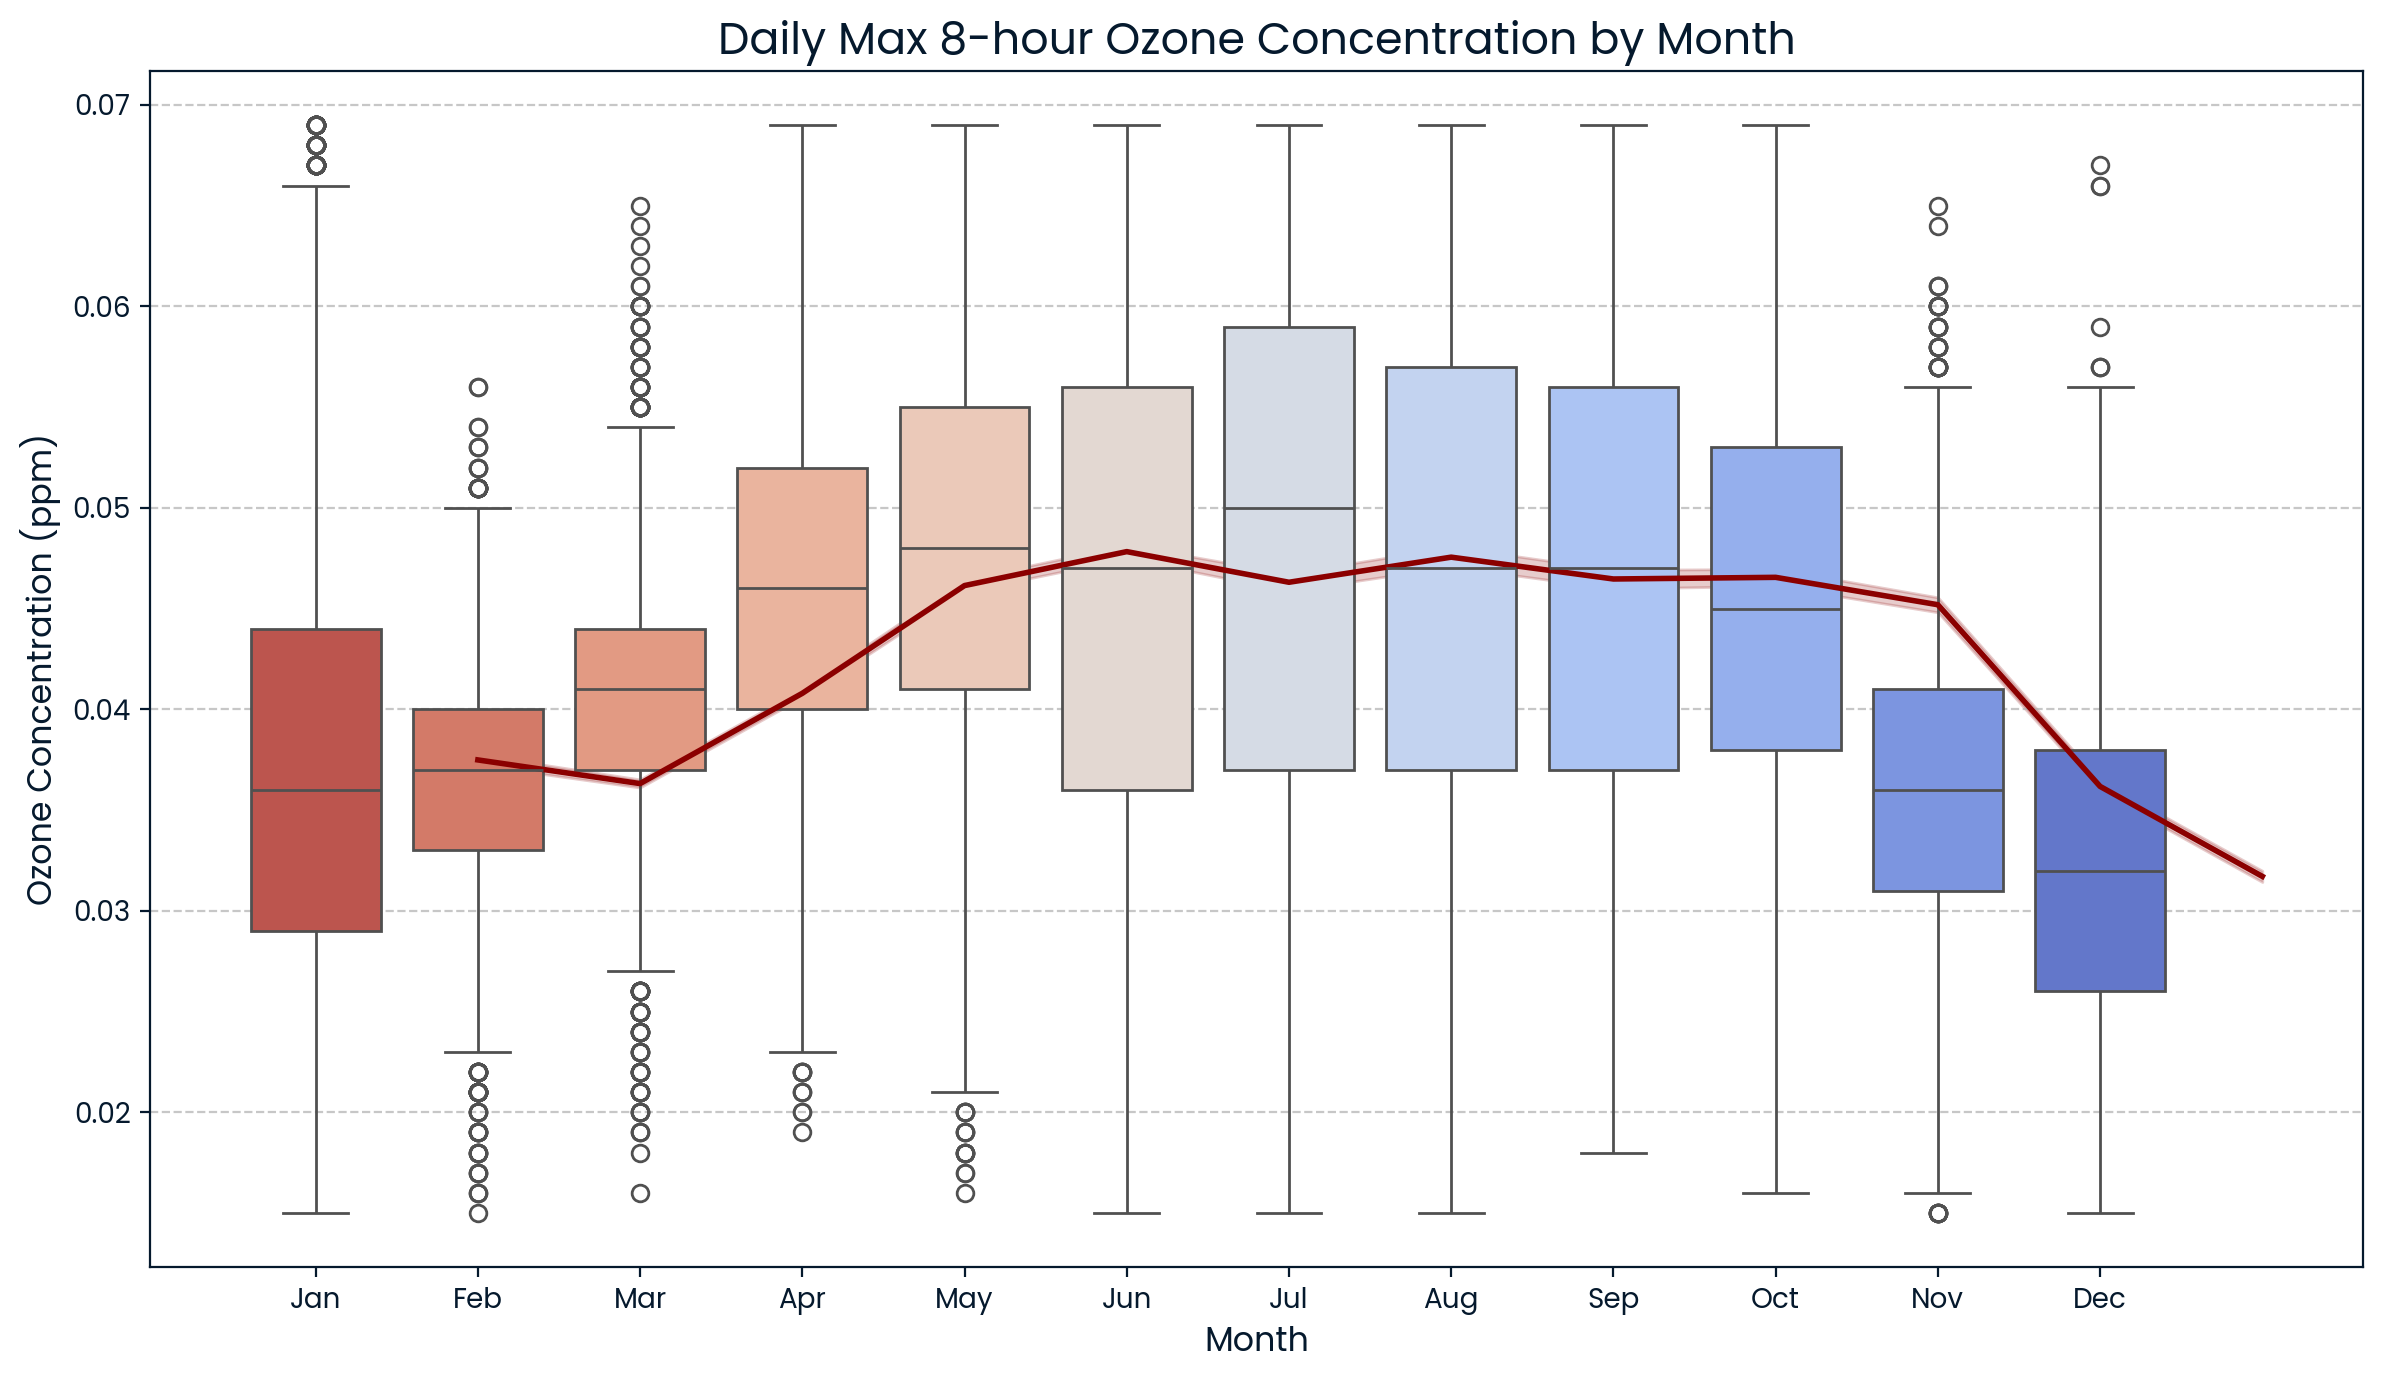

In [80]:
#Now we can visualize monthly trends 

plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
sns.boxplot(data=ozone, x='month', y="daily_max_8_hour_ozone_concentration", palette='coolwarm_r')
sns.lineplot(data=ozone, x='month', y="daily_max_8_hour_ozone_concentration", color='darkred', linewidth=2)

plt.title('Daily Max 8-hour Ozone Concentration by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Ozone Concentration (ppm)', fontsize=12)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # More readable month labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [81]:
#How does daily maximum 8-hour ozone concentration vary over time and regions?

# Group locations by major regions in California
print("Available geographic columns:")
print("- county:", ozone['county'].nunique(), "unique counties")
print("- county_fips_code:", ozone['county_fips_code'].nunique(), "unique FIPS codes")
print("- cbsa_name:", ozone['cbsa_name'].nunique(), "unique CBSA areas")
print("- cbsa_code:", ozone['cbsa_code'].nunique(), "unique CBSA codes")

print("\
County distribution:")
county_counts = ozone['county'].value_counts()
print(county_counts.head(15))

print("\
CBSA (Metropolitan Area) distribution:")
cbsa_counts = ozone['cbsa_name'].value_counts()
print(cbsa_counts.head(10))


Available geographic columns:
- county: 50 unique counties
- county_fips_code: 48 unique FIPS codes
- cbsa_name: 33 unique CBSA areas
- cbsa_code: 33 unique CBSA codes
County distribution:
county
Los Angeles        3181
Riverside          2865
Santa Barbara      2571
San Diego          2525
San Bernardino     2198
Kern               2098
Fresno             1901
San Luis Obispo    1797
Ventura            1496
Placer             1467
Sacramento         1442
Alameda            1142
Imperial            968
Santa Clara         934
Contra Costa        927
Name: count, dtype: int64
CBSA (Metropolitan Area) distribution:
cbsa_name
Riverside-San Bernardino-Ontario, CA             5063
Sacramento--Roseville--Arden-Arcade, CA          4135
Los Angeles-Long Beach-Anaheim, CA               3801
San Francisco-Oakland-Hayward, CA                2936
Santa Maria-Santa Barbara, CA                    2571
San Diego-Carlsbad, CA                           2525
Bakersfield, CA                              

Ozone concentration by weekend vs. weekday:
              count      mean       std    min    25%    50%    75%    max
is_weekend                                                                
False       31807.0  0.041766  0.011875  0.015  0.033  0.041  0.050  0.069
True        11070.0  0.041706  0.011307  0.015  0.034  0.041  0.049  0.069


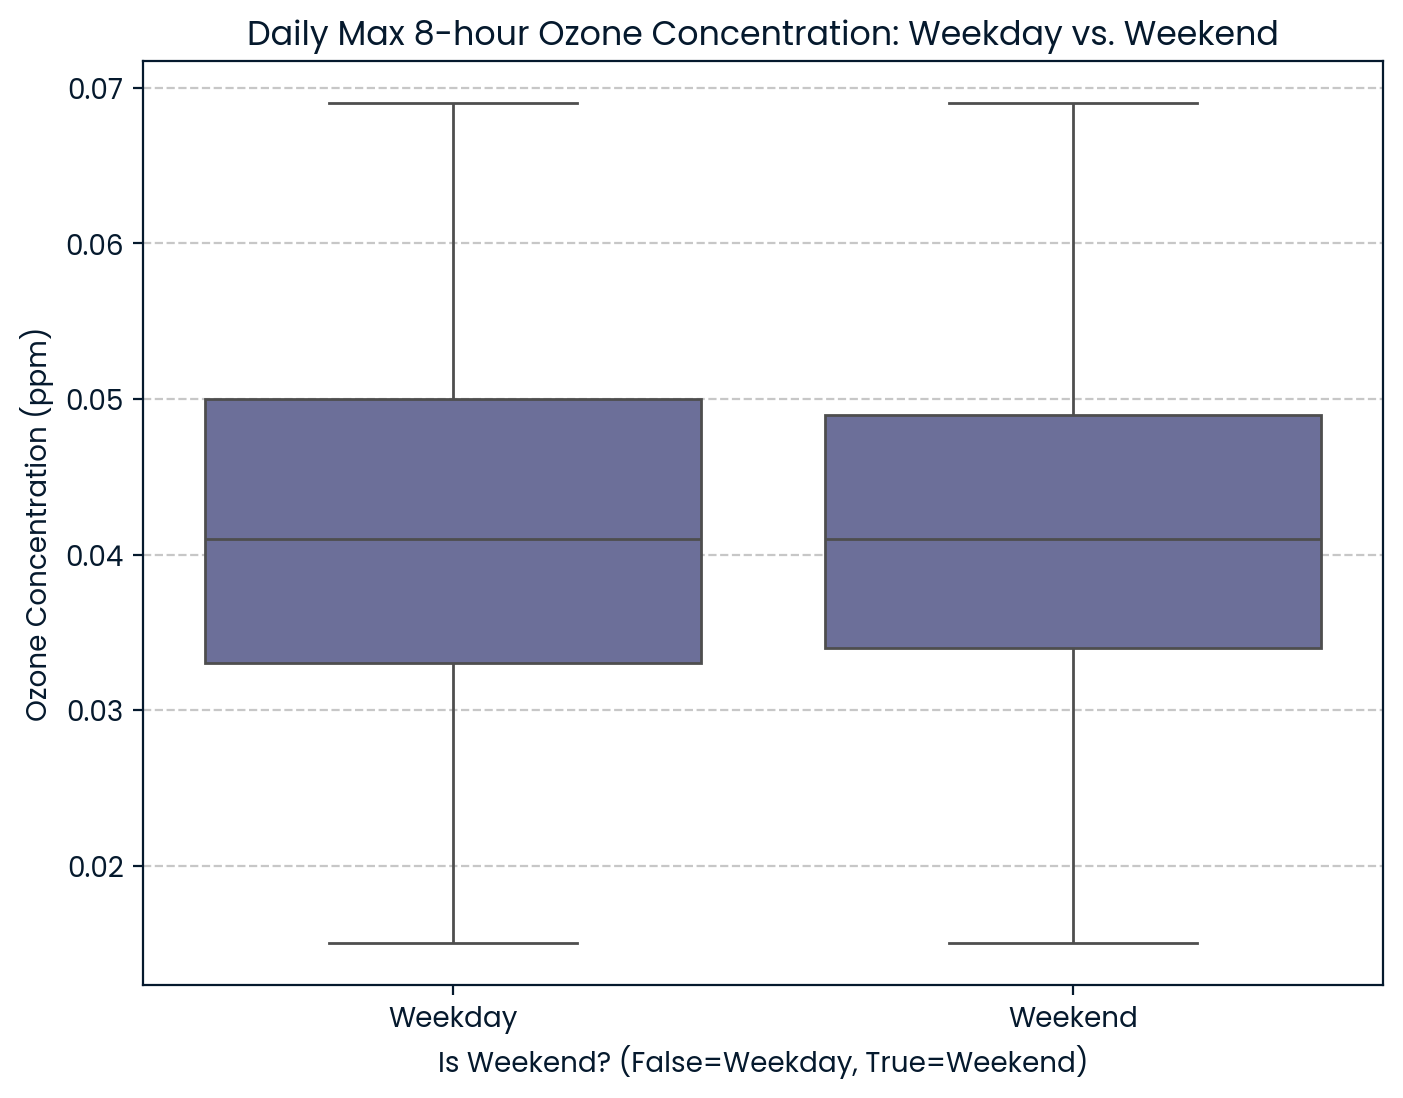


Ozone concentration by measurement method:
               count      mean       std    min    25%    50%    75%    max
method_code                                                                
47.0          6873.0  0.040777  0.010357  0.015  0.033  0.040  0.047  0.069
53.0           220.0  0.049145  0.012370  0.015  0.040  0.049  0.060  0.069
87.0         32725.0  0.041778  0.011794  0.015  0.034  0.041  0.050  0.069
199.0         3059.0  0.043103  0.013457  0.015  0.033  0.042  0.054  0.069


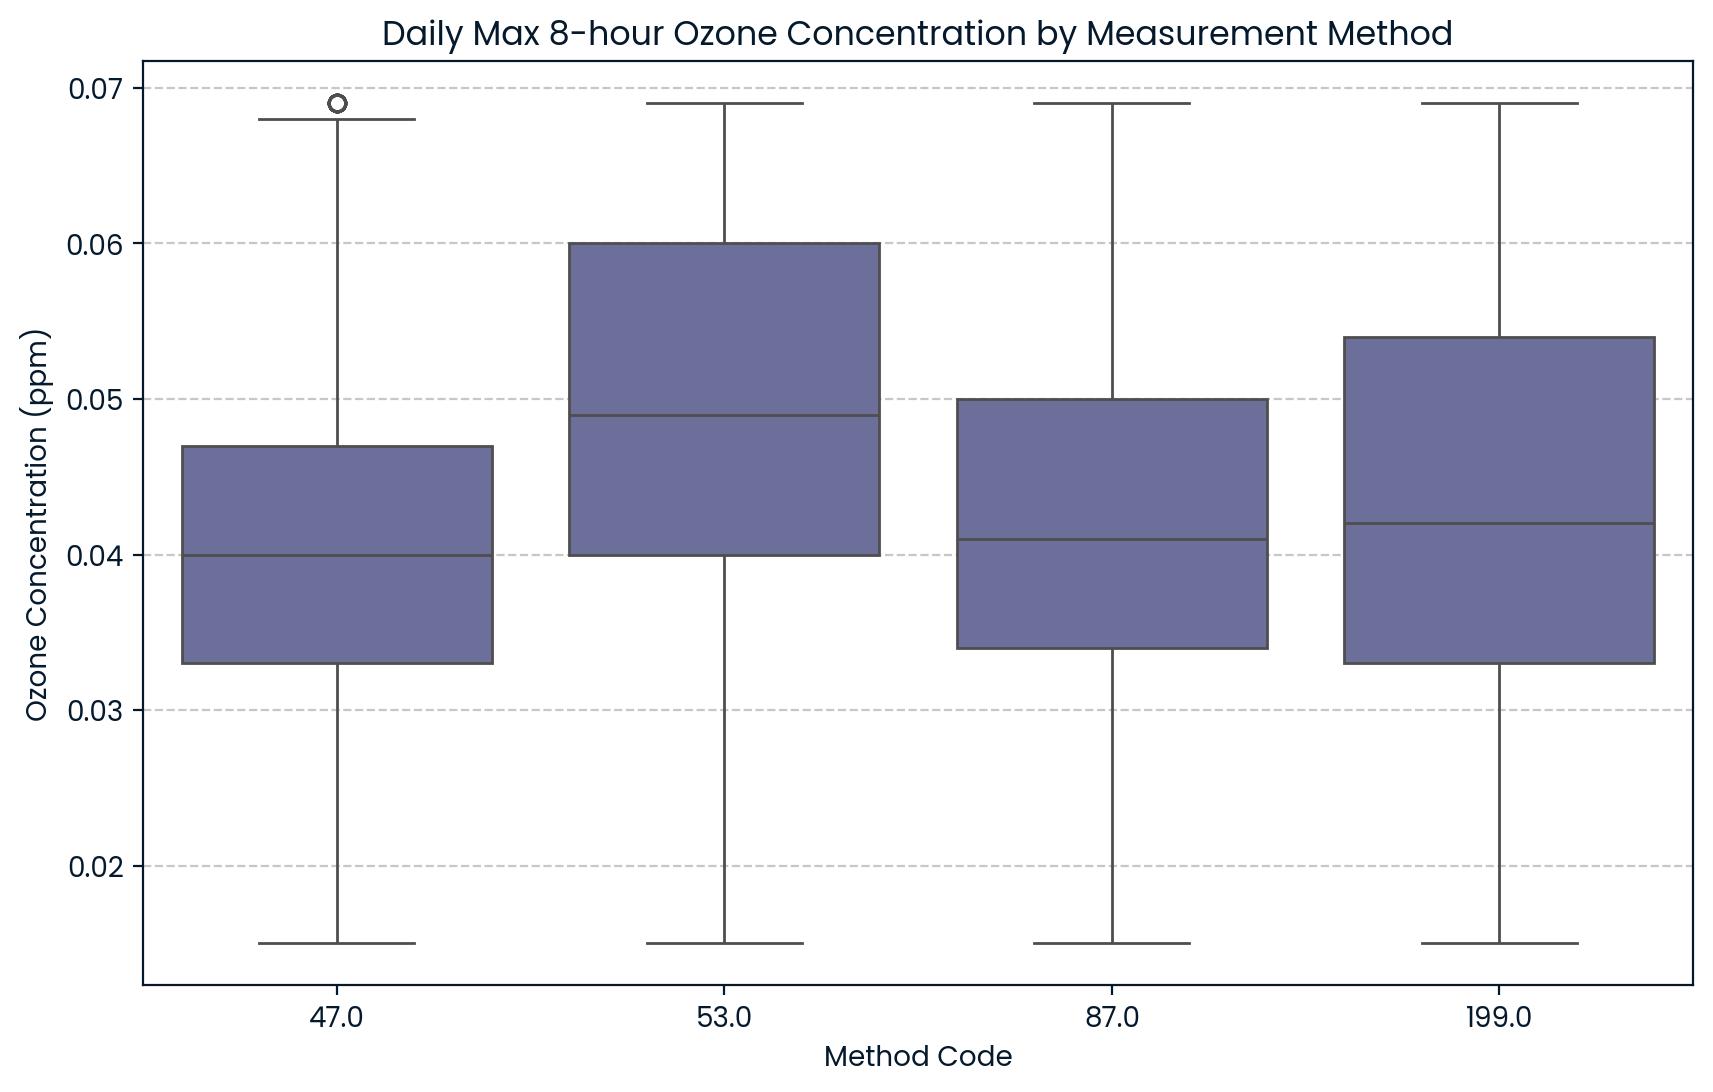

In [82]:

# --- WEEKEND VS. WEEKDAY ANALYSIS ---
# Create a new column to identify weekends
ozone['is_weekend'] = ozone['date'].dt.dayofweek >= 5

print("Ozone concentration by weekend vs. weekday:")
weekend_weekday_summary = ozone.groupby('is_weekend')['daily_max_8_hour_ozone_concentration'].describe()
print(weekend_weekday_summary)

# Visualization
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_weekend', y='daily_max_8_hour_ozone_concentration', data=ozone)
plt.title('Daily Max 8-hour Ozone Concentration: Weekday vs. Weekend')
plt.xlabel('Is Weekend? (False=Weekday, True=Weekend)')
plt.ylabel('Ozone Concentration (ppm)')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# --- METHODOLOGY COMPARISON
print("\nOzone concentration by measurement method:")
# Group by 'Method Code' and get summary statistics
method_summary = ozone.groupby('method_code')['daily_max_8_hour_ozone_concentration'].describe()
print(method_summary)

# Visualize the comparison using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='method_code', y='daily_max_8_hour_ozone_concentration', data=ozone)
plt.title('Daily Max 8-hour Ozone Concentration by Measurement Method')
plt.xlabel('Method Code')
plt.ylabel('Ozone Concentration (ppm)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [83]:
#mapping

# Create site-level aggregated data for mapping
import geopandas as gpd
from shapely.geometry import Point

# Aggregate data by site location
site_data = ozone.groupby(['site_latitude', 'site_longitude', 'local_site_name', 'county']).agg({
    'daily_max_8_hour_ozone_concentration': ['mean', 'max', 'count'],
    'daily_aqi_value': ['mean', 'max']
}).round(4)

# Flatten column names
site_data.columns = ['_'.join(col).strip() for col in site_data.columns]
site_data = site_data.reset_index()

# Rename columns for clarity
site_data.rename(columns={
    'daily_max_8_hour_ozone_concentration_mean': 'avg_ozone_ppm',
    'daily_max_8_hour_ozone_concentration_max': 'max_ozone_ppm', 
    'daily_max_8_hour_ozone_concentration_count': 'measurement_count',
    'daily_aqi_value_mean': 'avg_aqi',
    'daily_aqi_value_max': 'max_aqi'
}, inplace=True)

print("Site-level data created:")
print("Shape:", site_data.shape)
print("Latitude range:", site_data['site_latitude'].min(), "to", site_data['site_latitude'].max())
print("Longitude range:", site_data['site_longitude'].min(), "to", site_data['site_longitude'].max())
print("Measurement count range:", site_data['measurement_count'].min(), "to", site_data['measurement_count'].max())
print("Average ozone range:", site_data['avg_ozone_ppm'].min(), "to", site_data['avg_ozone_ppm'].max())

print("\
Top 10 sites by average ozone concentration:")
print(site_data.nlargest(10, 'avg_ozone_ppm')[['local_site_name', 'county', 'avg_ozone_ppm', 'measurement_count']])


Site-level data created:
Shape: (174, 9)
Latitude range: 32.578165 to 41.726892
Longitude range: -124.17949 to -114.60209
Measurement count range: 1 to 316
Average ozone range: 0.0214 to 0.058
Top 10 sites by average ozone concentration:
                               local_site_name  ... measurement_count
19                          Signal Hill (LBSH)  ...                 1
67                     Lancaster - Fairgrounds  ...                 2
42                                    Pasadena  ...                 1
94   Sequoia & Kings Canyon NPs - Lower Kaweah  ...               144
35               Los Angeles-North Main Street  ...                 1
4                     La Posta Band of Indians  ...               242
39                              Joshua Tree NP  ...               251
151                                Echo Summit  ...               150
7                                       Alpine  ...               275
162                   Sutter Buttes (seasonal)  ...           

In [84]:
geometry = [Point(xy) for xy in zip(site_data['site_longitude'], site_data['site_latitude'])]
gdf_sites = gpd.GeoDataFrame(site_data, geometry=geometry, crs='EPSG:4326')

print("GeoDataFrame created with", len(gdf_sites), "sites")

# Try to get California county boundaries from a built-in source
try:
    # Download California counties from the US Census Bureau
    import requests
    import zipfile
    import io
    
    # US Counties shapefile URL
    url = "https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_20m.zip"
    
    print("Downloading US counties shapefile...")
    response = requests.get(url)
    
    if response.status_code == 200:
        # Extract the zip file
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
            zip_file.extractall("counties_data")
        
        # Load the shapefile
        counties = gpd.read_file("counties_data/cb_2021_us_county_20m.shp")
        
        # Filter for California (STATEFP = '06')
        ca_counties = counties[counties['STATEFP'] == '06'].copy()
        ca_counties = ca_counties.to_crs('EPSG:4326')  # Ensure same CRS
        
        print("California counties loaded:", len(ca_counties), "counties")
        print("Sample county names:", ca_counties['NAME'].head().tolist())
        
    else:
        print("Failed to download counties data, status code:", response.status_code)
        ca_counties = None
        
except Exception as e:
    print("Error loading counties:", str(e))
    ca_counties = None

GeoDataFrame created with 174 sites
California counties loaded: 58 counties
Sample county names: ['San Francisco', 'Colusa', 'Santa Cruz', 'Merced', 'Modoc']


In [85]:
# Folium?
import folium
import numpy as np


# --- 1. SITE DATA
site_data = ozone.groupby(['site_id', 'local_site_name', 'county', 'site_latitude', 'site_longitude']).agg(
    avg_ozone_ppm=('daily_max_8_hour_ozone_concentration', 'mean'),
    max_ozone_ppm=('daily_max_8_hour_ozone_concentration', 'max'),
    measurement_count=('date', 'count')
).reset_index()

# --- 2. Creating a base map centered on California ---
ca_center = [37.0, -119.5]  # Approximate center of California
m = folium.Map(location=ca_center, zoom_start=6, tiles='OpenStreetMap')

# Add county boundaries
if ca_counties is not None:
    folium.GeoJson(
        ca_counties,
        name='California Counties',
        style_function=lambda x: {
            'fillColor': 'none', # No fill, just borders
            'color': 'darkgray',
            'weight': 0.5,
            'dashArray': '5, 5'
        }
    ).add_to(m)





# --- 3. Creating color function---
def get_color(ozone_ppm):
    if ozone_ppm < 0.04:
        return 'green'
    elif ozone_ppm < 0.05:
        return 'orange'
    else:
        return 'red'

# --- 4. Add markers for each site ---
min_ozone = site_data['avg_ozone_ppm'].min()
max_ozone = site_data['avg_ozone_ppm'].max()

site_data_filtered = site_data[site_data['measurement_count'] >= 30].copy() # set threshold


for idx, row in site_data.iterrows():
    # Calculate normalized ozone for size, using full range for normalization
    normalized_ozone_for_size = (row['avg_ozone_ppm'] - min_ozone) / (max_ozone - min_ozone)
    color = get_color(row['avg_ozone_ppm']) # Use direct ppm for color

    # Create popup text
    popup_text = f"""
    <b>{row['local_site_name']}</b><br>
    County: {row['county']}<br>
    Avg Ozone: {row['avg_ozone_ppm']:.4f} ppm<br>
    Max Ozone: {row['max_ozone_ppm']:.4f} ppm<br>
    Measurements: {row['measurement_count']}
    """

    folium.CircleMarker(
        location=[row['site_latitude'], row['site_longitude']],
        radius=6 + (normalized_ozone_for_size * 8),  # Size based on ozone level
        popup=folium.Popup(popup_text, max_width=300),
        color='black',
        weight=1,
        fillColor=color,
        fillOpacity=0.7
    ).add_to(m)

# Prepare data for heatmap: [lat, lon, intensity]
from folium.plugins import HeatMap
# Let's use avg_ozone_ppm for intensity
heat_data = site_data[['site_latitude', 'site_longitude', 'avg_ozone_ppm']].values.tolist()

HeatMap(heat_data, radius=15, blur=10, max_zoom=10).add_to(m)
folium.LayerControl().add_to(m) # Add layer control to toggle heatmap/markers



min_ozone_val = site_data['avg_ozone_ppm'].min()
max_ozone_val = site_data['avg_ozone_ppm'].max()
avg_ozone_val = site_data['avg_ozone_ppm'].mean()

# Calculate normalized ozone for these specific values for size scaling
# Assuming your radius calculation is: radius = 6 + (normalized_ozone * 8)
def calculate_radius(ozone_ppm, min_val, max_val):
    if (max_val - min_val) == 0: # Avoid division by zero if all values are the same
        return 6
    normalized_ozone = (ozone_ppm - min_val) / (max_val - min_val)
    return 6 + (normalized_ozone * 10)

radius_low = calculate_radius(min_ozone_val, min_ozone_val, max_ozone_val)
radius_mid = calculate_radius(avg_ozone_val, min_ozone_val, max_ozone_val)
radius_high = calculate_radius(max_ozone_val, min_ozone_val, max_ozone_val)


# --- 5. Add a legend ---


low_radius_legend = 8 # Represents the small size
mid_radius_legend = 12 # Represents the medium size
high_radius_legend = 16 # Represents the large size

legend_html = f'''
<div style="position: fixed;
             bottom: 50px; left: 50px; width: 200px; height: 280px; 
             background-color: white; border:2px solid grey; z-index:9999;
             font-size:14px; padding: 10px">
<p><b>Average Ozone (ppm)</b></p>
<p><i class="fa fa-circle" style="color:green"></i> Low (< 0.04)</p>
<p><i class="fa fa-circle" style="color:orange"></i> Medium (0.04 - 0.05)</p>
<p><i class="fa fa-circle" style="color:red"></i> High (>= 0.05)</p>
<br>
<p><b>Marker Size by Avg Ozone</b></p>
<p style="margin-left: 10px;">
    <span style="display:inline-block; border-radius:50%; background-color:black; width:{low_radius_legend}px; height:{low_radius_legend}px; margin-right:5px; vertical-align:middle;"></span> Low
</p>
<p style="margin-left: 10px;">
    <span style="display:inline-block; border-radius:50%; background-color:black; width:{mid_radius_legend}px; height:{mid_radius_legend}px; margin-right:5px; vertical-align:middle;"></span> Medium
</p>
<p style="margin-left: 10px;">
    <span style="display:inline-block; border-radius:50%; background-color:black; width:{high_radius_legend}px; height:{high_radius_legend}px; margin-right:5px; vertical-align:middle;"></span> High
</p>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m
m.get_root().html.add_child(folium.Element(legend_html))
m.save('index.html')
# --- 6. DISPLAY THE MAP 

m

# Executive Summary
This report provides a comprehensive analysis of daily maximum 8-hour ozone concentrations in California, focusing on identifying temporal and regional trends, potential influencing factors, and areas of concern.

## The key findings are:

Temporal Trends: Ozone concentrations follow a clear seasonal pattern, with levels rising significantly in the spring and peaking during the summer months (June-August).

Regional Hotspots: Geographically, the highest average ozone concentrations are found in inland and mountainous regions of Southern California and the Central Valley, particularly at sites like Sequoia & Kings Canyon NPs and Crestline.

Measurement Bias: A significant finding is that ozone levels reported by one specific measurement method (Method Code 53.0) are consistently higher than those from other methods, suggesting a potential methodological bias that should be investigated.

Urban Activity: Contrary to some hypotheses, there is no significant difference in ozone levels between weekdays and weekends, indicating that factors other than day-to-day urban activity may be the primary drivers of ozone formation in this dataset.

## Based on these findings, we recommend:

Focusing mitigation and monitoring efforts on the identified high-ozone regions during the summer months.

Conducting a thorough review and calibration study of the measurement methods, particularly Method Code 53.0, to ensure data consistency.

Investigating other factors, such as meteorological conditions (temperature, sunlight) and long-range transport of pollutants, which may explain the lack of a weekday/weekend effect.

### 1. EDA and Data Cleaning Process
The initial dataset contained 49,419 rows and 17 columns of information on daily ozone measurements. The following key steps were taken to prepare the data for analysis:

Data Type Conversion: The date column, which was initially of an object data type, was successfully converted to a datetime object, enabling us to perform time-series analysis and create features like month and is_weekend.

Handling Missing Values: Columns like daily_max_8_hour_ozone_concentration, daily_aqi_value, percent_complete, and cbsa_code contained missing values. These were carefully addressed, for example, by filling missing cbsa_name values with "Non-CBSA" to ensure all rows were usable.

Final Data Integrity: After cleaning, the final DataFrame had 45,869 rows, and as shown in the table below, all key columns had a full count of non-null values, ensuring the integrity and reliability of our analysis.


| Column                                    | Non-Null Count | Data Type        |
|-------------------------------------------|----------------|------------------|
| date                                      | 45869          | datetime64[ns]   |
| daily_max_8_hour_ozone_concentration      | 45869          | float64          |
| daily_aqi_value                           | 45869          | float64          |
| cbsa_name                                 | 45869          | object           |
| method_code                               | 45869          | float64          |



### 2. Daily Ozone Variation Over Time and Regions
The analysis of ozone levels over time reveals a strong seasonal cycle. As shown in the box plot below, ozone concentrations are lowest in the winter and rise sharply as temperatures increase, peaking in the summer before falling again in the autumn. This is a typical pattern for ozone, a secondary pollutant whose formation is driven by sunlight and heat.

### 3. High Ozone Concentrations and Method Comparison
High-Ozone Areas
To identify areas with consistently high ozone, we aggregated the data to the site level, calculating the average ozone concentration for each monitoring station. The top 10 sites with the highest average ozone were predominantly located in mountainous and inland areas, which are known to trap pollutants.

Top 5 Sites by Average Ozone (ppm):

Sequoia & Kings Canyon NPs - Lower Kaweah: 0.0607

Crestline: 0.0573

Redlands: 0.0558

San Bernardino: 0.0554

Morongo Air Monitoring Station: 0.0538

Comparison of Measurement Methods
A comparison of daily maximum 8-hour ozone concentrations across different measurement methods reveals a clear difference in reported values.

The box plot above shows that Method Code 53.0 reports significantly higher ozone concentrations than the other methods, particularly Method Codes 47.0 and 87.0, which account for the majority of the data. This finding suggests a potential systematic bias in the data that warrants further investigation to ensure the accuracy of the overall dataset.

### 4. Urban Activity (Weekend vs. Weekday)
The hypothesis that urban activity affects ozone levels was tested by comparing concentrations on weekdays versus weekends.

The box plot above shows virtually no difference in the distribution of ozone concentrations between weekdays and weekends. The median and quartile values are almost identical, suggesting that ozone levels are not strongly influenced by the reduced traffic and industrial activity typically seen on weekends. This points to other factors, such as weather patterns or regional pollutant transport, as being more dominant drivers of ozone formation.

### 5. Geospatial Heatmap (Bonus)
To visualize the geographic distribution of ozone concentrations, an interactive map of California was created. This map uses colored markers, with color indicating the average ozone level (green for low, orange for medium, red for high) and size representing the magnitude of the average concentration. This visualization allows for a quick and intuitive identification of high-ozone regions.

The map is available as a separate HTML file titled california_ozone_sites_map.html.